# Script to scrape IQAir data (daily and hourly)

In [1]:
import requests
import pandas as pd

def location_data(iqair_url):
    try:
        location = iqair_url.removeprefix("https://www.iqair.com/").strip("/")
        location_id = requests.get(f"https://website-api.airvisual.com/v1/routes/{location}").json()['id']
        measurements_data = requests.get(f"https://website-api.airvisual.com/v1/cities/{location_id}/measurements").json()
        return measurements_data
        
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def extract_concentration(data_list, mode="hourly"):
    records = []
    for entry in data_list:
        ts = entry.get('ts')
        row = {}

        if mode == "daily" and ts:
            row['date'] = ts.split("T")[0]  # Keep only YYYY-MM-DD
        else:
            row['timestamp'] = ts

        for key, value in entry.items():
            if isinstance(value, dict) and 'concentration' in value:
                row[key] = value['concentration']
        records.append(row)
    return pd.DataFrame(records)

def location_data_to_csv(iqair_url, hourly_csv='hourly.csv', daily_csv='daily.csv'):
    data = location_data(iqair_url)
    if data is None:
        print("No data retrieved.")
        return None, None

    measurements = data.get('measurements', {})
    hourly_data = measurements.get('hourly', [])
    daily_data = measurements.get('daily', [])

    hourly_df = extract_concentration(hourly_data, mode="hourly")
    daily_df = extract_concentration(daily_data, mode="daily")

    hourly_df.to_csv(hourly_csv, index=False)
    daily_df.to_csv(daily_csv, index=False)

    return hourly_df, daily_df

In [2]:
url = "https://www.iqair.com/china/sichuan/panzhihua"
hourly, daily = location_data_to_csv(url, "panzhihua_hourly.csv", "panzhihua_daily.csv")
print(hourly.head())
print(daily.head())

                  timestamp  pm25  pm10    o3   no2   so2    co
0  2025-07-08T19:00:00.000Z  14.0  32.0   2.0  28.0  19.0  1050
1  2025-07-08T20:00:00.000Z  16.0  34.0   7.0  23.0  17.0   850
2  2025-07-08T21:00:00.000Z  10.5  28.0  45.5  11.5  11.5   600
3  2025-07-08T22:00:00.000Z   5.5  19.5  52.0   7.0   7.5   600
4  2025-07-08T23:00:00.000Z   8.5  27.0  45.0  14.0   8.0   600
         date  pm25  pm10     o3   no2   so2     co
0  2025-06-10   NaN   NaN    NaN   NaN   NaN    NaN
1  2025-06-11  21.1  42.0   95.6  19.0  10.3  741.7
2  2025-06-12  24.3  48.3  101.4  19.9  12.5  816.0
3  2025-06-13  30.3  53.5  102.7  19.8  17.1  864.6
4  2025-06-14  24.5  42.1  105.1  12.5  14.1  824.0


# Scrape and plot hourly pollutant data from IQAir

Columns in DataFrame: ['timestamp', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
                  timestamp  pm25  pm10    o3   no2   so2    co
0 2025-07-08 19:00:00+00:00  14.0  32.0   2.0  28.0  19.0  1050
1 2025-07-08 20:00:00+00:00  16.0  34.0   7.0  23.0  17.0   850
2 2025-07-08 21:00:00+00:00  10.5  28.0  45.5  11.5  11.5   600
3 2025-07-08 22:00:00+00:00   5.5  19.5  52.0   7.0   7.5   600
4 2025-07-08 23:00:00+00:00   8.5  27.0  45.0  14.0   8.0   600


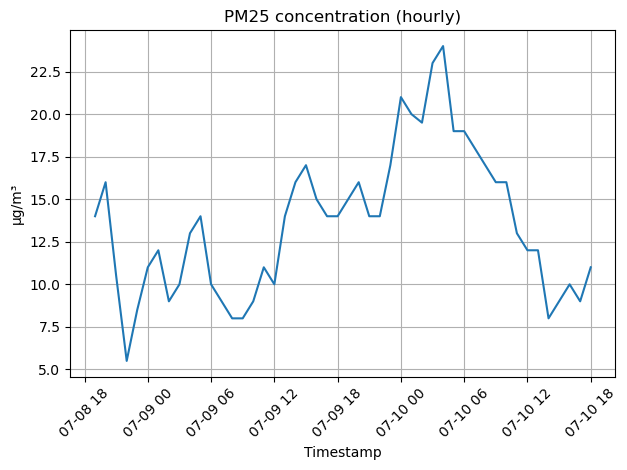

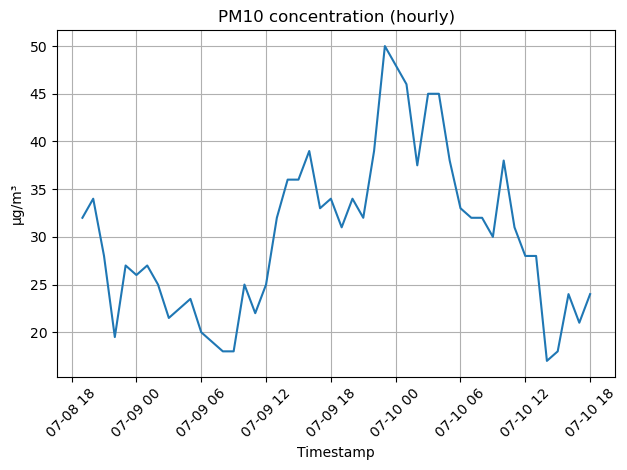

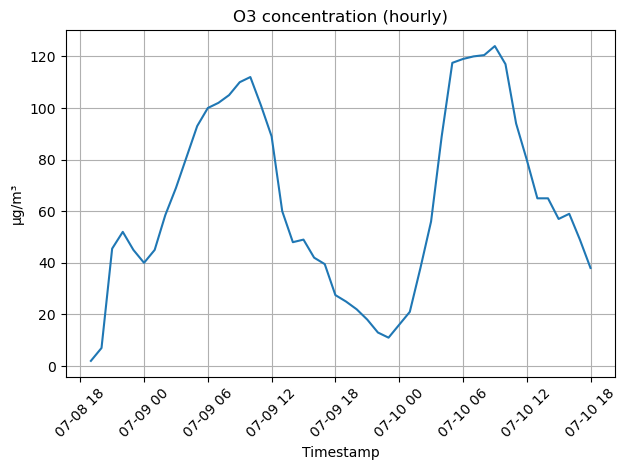

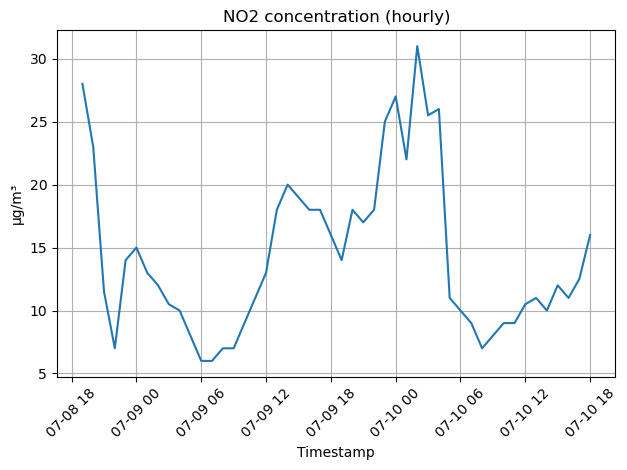

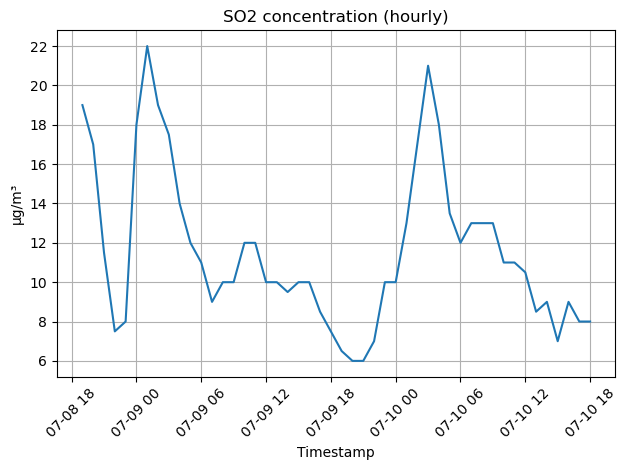

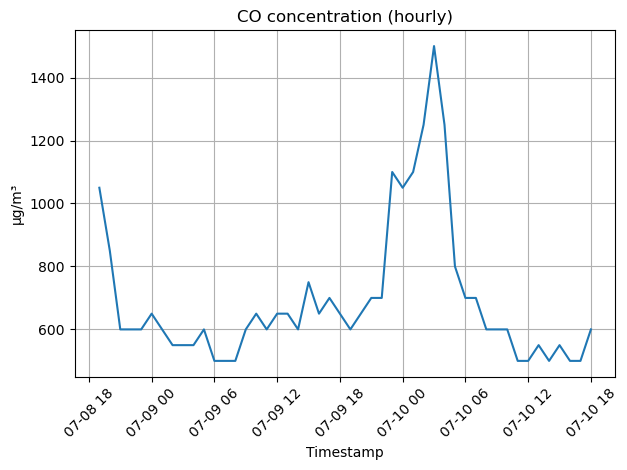

In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

iqair_url = "https://www.iqair.com/china/sichuan/panzhihua"   # <-- put any city page here
location_path = iqair_url.removeprefix("https://www.iqair.com/").strip("/")

routes_resp = requests.get(f"https://website-api.airvisual.com/v1/routes/{location_path}")
location_id = routes_resp.json()["id"]

meas_resp = requests.get(f"https://website-api.airvisual.com/v1/cities/{location_id}/measurements")
measurements = meas_resp.json()["measurements"]

hourly_raw = measurements["hourly"]
rows = []

for entry in hourly_raw:
    row = {}
    ts = entry.get("ts")
    if ts is None:
        continue
    row["timestamp"] = pd.to_datetime(ts)

    for key, value in entry.items():
        if isinstance(value, dict) and "concentration" in value:
            row[key] = value["concentration"]
    rows.append(row)

hourly_df = pd.DataFrame(rows).sort_values("timestamp")
print("Columns in DataFrame:", hourly_df.columns.tolist())
print(hourly_df.head())

pollutant_cols = [col for col in hourly_df.columns if col != "timestamp"]

for pollutant in pollutant_cols:
    plt.figure()
    plt.plot(hourly_df["timestamp"], hourly_df[pollutant])
    plt.title(f"{pollutant.upper()} concentration (hourly)")
    plt.xlabel("Timestamp")
    plt.ylabel("µg/m³")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
